In [1]:
#!pip install folium --upgrade
#!pip install matplotlib
#!pip install colour

In [1]:
import pandas as pd
import numpy as np
import urllib.request, json
import matplotlib
import matplotlib.pyplot as plt
import unicodedata
import folium
from folium.plugins import TimeSliderChoropleth
import geopandas as gp
from datetime import datetime
from colour import Color

In [2]:
print(folium.__version__)

0.11.0


## Primero vamos a trabajar la data del ministerio...

Este producto trae lso casos confirmados por comuna a través dle tiempo:

In [3]:
#Nota mental: siempre importar los Raw de GitHub, perdí demasiado tiempo dandome cuenta de algo tan tonto...

df = pd.read_csv("https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto1/Covid-19.csv",header=0)
df.head()

,Region,Codigo region,Comuna,Codigo comuna,Poblacion,2020-03-30,2020-04-01,2020-04-03,2020-04-06,2020-04-08,...,2020-06-12,2020-06-15,2020-06-19,2020-06-23,2020-06-28,2020-07-01,2020-07-05,2020-07-10,2020-07-13,Tasa
0,Arica y Parinacota,15,Arica,15101.0,247552.0,6.0,6.0,12.0,41.0,63.0,...,1046.0,1176.0,1371.0,1533.0,1758.0,1887.0,2139.0,2464.0,2721.0,1099.2
1,Arica y Parinacota,15,Camarones,15102.0,1233.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,648.8
2,Arica y Parinacota,15,General Lagos,15202.0,810.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arica y Parinacota,15,Putre,15201.0,2515.0,0.0,0.0,0.0,0.0,0.0,...,2.0,3.0,9.0,10.0,11.0,11.0,11.0,26.0,28.0,1113.3
4,Arica y Parinacota,15,Desconocido Arica y Parinacota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.0,1.0,3.0,1.0,3.0,3.0,3.0,NaN


In [4]:
df.shape

(362, 39)

In [5]:
df.Region.unique()

array(['Arica y Parinacota', 'Tarapacá', 'Antofagasta', 'Atacama',
       'Coquimbo', 'Valparaíso', 'Metropolitana', 'O’Higgins', 'Maule',
       'Ñuble', 'Biobío', 'Araucanía', 'Los Ríos', 'Los Lagos', 'Aysén',
       'Magallanes'], dtype=object)

In [6]:
def elimina_tildes(cadena):
    s = ''.join((c for c in unicodedata.normalize('NFD',cadena) if unicodedata.category(c) != 'Mn'))
    s = s.replace(" ", "_")
    return s

In [7]:
df['Comuna'] = df['Comuna'].apply(lambda x: elimina_tildes(x))

In [8]:
df_metro = df[df['Region'] == 'Metropolitana'].copy()
df_metro.drop(columns={'Region', 'Codigo region', 'Tasa'}, inplace=True)
df_metro.head()

,Comuna,Codigo comuna,Poblacion,2020-03-30,2020-04-01,2020-04-03,2020-04-06,2020-04-08,2020-04-10,2020-04-13,...,2020-06-08,2020-06-12,2020-06-15,2020-06-19,2020-06-23,2020-06-28,2020-07-01,2020-07-05,2020-07-10,2020-07-13
88,Alhue,13502.0,7405.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,16.0,22.0,52.0,63.0,75.0,84.0,98.0,122.0,137.0
89,Buin,13402.0,109641.0,7.0,8.0,14.0,20.0,20.0,29.0,36.0,...,815.0,978.0,1044.0,1428.0,1556.0,1701.0,1776.0,1862.0,1998.0,2065.0
90,Calera_de_Tango,13403.0,28525.0,6.0,7.0,7.0,7.0,8.0,8.0,10.0,...,146.0,186.0,200.0,293.0,342.0,406.0,428.0,463.0,490.0,503.0
91,Cerrillos,13102.0,88956.0,0.0,4.0,4.0,5.0,11.0,21.0,29.0,...,1231.0,1410.0,1545.0,2036.0,2204.0,2384.0,2468.0,2573.0,2706.0,2772.0
92,Cerro_Navia,13103.0,142465.0,19.0,21.0,26.0,31.0,36.0,42.0,57.0,...,2149.0,2576.0,3075.0,4313.0,4696.0,5152.0,5307.0,5581.0,5759.0,5861.0


In [9]:
df_id_comunas = df_metro[['Comuna', 'Codigo comuna']].copy()
df_id_comunas.dropna(inplace=True)
df_id_comunas['Codigo comuna'] = df_id_comunas['Codigo comuna'].astype(int)
df_id_comunas.head()

,Comuna,Codigo comuna
88,Alhue,13502
89,Buin,13402
90,Calera_de_Tango,13403
91,Cerrillos,13102
92,Cerro_Navia,13103


In [10]:
#Viva le función melt, viva... Sirve para "Despivotear" DataFrames
unpivoted = df_metro.melt(id_vars=['Comuna', 'Codigo comuna', 'Poblacion'], var_name='fecha', value_name='Contagiados')
unpivoted

,Comuna,Codigo comuna,Poblacion,fecha,Contagiados
0,Alhue,13502.0,7405.0,2020-03-30,0.0
1,Buin,13402.0,109641.0,2020-03-30,7.0
2,Calera_de_Tango,13403.0,28525.0,2020-03-30,6.0
3,Cerrillos,13102.0,88956.0,2020-03-30,0.0
4,Cerro_Navia,13103.0,142465.0,2020-03-30,19.0
...,...,...,...,...,...
1744,Santiago,13101.0,503147.0,2020-07-13,13852.0
1745,Talagante,13601.0,81838.0,2020-07-13,1480.0
1746,Tiltil,13303.0,21477.0,2020-07-13,518.0
1747,Vitacura,13132.0,96774.0,2020-07-13,1380.0


In [11]:
fechas = unpivoted.fecha.unique()
fechas

array(['2020-03-30', '2020-04-01', '2020-04-03', '2020-04-06',
       '2020-04-08', '2020-04-10', '2020-04-13', '2020-04-15',
       '2020-04-17', '2020-04-20', '2020-04-24', '2020-04-27',
       '2020-05-01', '2020-05-04', '2020-05-08', '2020-05-11',
       '2020-05-15', '2020-05-18', '2020-05-22', '2020-05-25',
       '2020-05-29', '2020-06-01', '2020-06-05', '2020-06-08',
       '2020-06-12', '2020-06-15', '2020-06-19', '2020-06-23',
       '2020-06-28', '2020-07-01', '2020-07-05', '2020-07-10',
       '2020-07-13'], dtype=object)

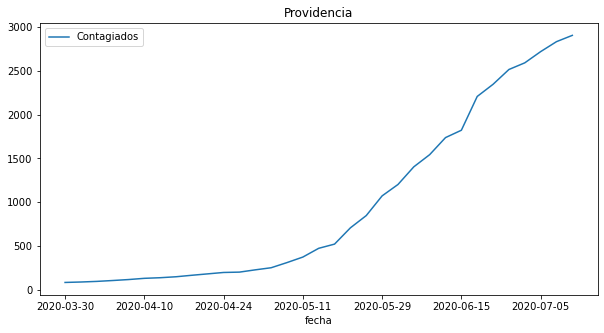

In [12]:
Comuna = 'Providencia'
sample = unpivoted[unpivoted['Comuna'] == Comuna]
sample.plot(x='fecha', y='Contagiados', title=Comuna, figsize=(10,5))

In [13]:
pivoted = unpivoted.pivot(index='fecha' , columns = 'Comuna', values='Contagiados').reset_index()
pivoted.dropna(inplace=True, axis='columns')
pivoted.head()

Comuna,fecha,Alhue,Buin,Calera_de_Tango,Cerrillos,Cerro_Navia,Colina,Conchali,Curacavi,El_Bosque,...,San_Bernardo,San_Joaquin,San_Jose_de_Maipo,San_Miguel,San_Pedro,San_Ramon,Santiago,Talagante,Tiltil,Vitacura
0,2020-03-30,0.0,7.0,6.0,0.0,19.0,32.0,14.0,5.0,18.0,...,32.0,13.0,0.0,25.0,0.0,0.0,127.0,0.0,0.0,83.0
1,2020-04-01,0.0,8.0,7.0,4.0,21.0,39.0,18.0,5.0,28.0,...,41.0,24.0,0.0,32.0,0.0,6.0,156.0,5.0,0.0,90.0
2,2020-04-03,0.0,14.0,7.0,4.0,26.0,47.0,22.0,5.0,35.0,...,53.0,28.0,0.0,39.0,0.0,9.0,173.0,6.0,0.0,100.0
3,2020-04-06,0.0,20.0,7.0,5.0,31.0,50.0,32.0,8.0,37.0,...,74.0,36.0,0.0,49.0,0.0,9.0,234.0,11.0,0.0,114.0
4,2020-04-08,0.0,20.0,8.0,11.0,36.0,62.0,38.0,9.0,46.0,...,79.0,42.0,0.0,56.0,0.0,12.0,271.0,14.0,4.0,114.0


In [14]:
#pivoted.plot(figsize=(30,10))

## Ahora comenzamos con la parte del mapa...

In [15]:
#!wget https://www.bcn.cl/siit/obtienearchivo?id=repositorio/10221/10396/1/division_comunal.zip
#!mv obtienearchivo\?id\=repositorio%2F10221%2F10396%2F1%2Fdivision_comunal.zip comunal.zip
#!unzip comunal
#!pip install geopandas

df_geo = gp.read_file('division_comunal.shp')
#df.NOM_REG.unique()

In [16]:
df_geo.NOM_REG.unique()

array(['Región de La Araucanía', 'Región de Los Lagos',
       'Región de Los Ríos', 'Región de Aysén del Gral.Ibañez del Campo',
       'Región de Antofagasta', 'Región de Atacama',
       "Región del Libertador Bernardo O'Higgins", 'Región de Coquimbo',
       'Región de Valparaíso', 'Región del Bío-Bío', 'Región del Maule',
       'Región Metropolitana de Santiago',
       'Región de Magallanes y Antártica Chilena', 'Zona sin demarcar',
       'Región de Arica y Parinacota', 'Región de Tarapacá'], dtype=object)

In [17]:
rmdf = df_geo[df_geo.NOM_PROV=='Santiago'].copy()
rmdf['NOM_COM'] = rmdf['NOM_COM'].apply(lambda x: elimina_tildes(x))
rmdf = rmdf.merge(df_id_comunas, left_on='NOM_COM', right_on='Comuna')
print('Procesamos %d comunas en la Provincia de Santiago' %len(rmdf))

Procesamos 32 comunas en la Provincia de Santiago


In [18]:
rmdf.to_pickle('rm.pk')   # 780K! upload to quant.cl for reference (just repeat the above)

In [19]:
rmdf.head(5)

,NOM_REG,NOM_PROV,NOM_COM,SHAPE_LENG,DIS_ELEC,CIR_SENA,COD_COMUNA,SHAPE_Le_1,SHAPE_Area,geometry,Comuna,Codigo comuna
0,Región Metropolitana de Santiago,Santiago,Independencia,11488.695747,19,7,1310,11718.687086,7.514746e+06,"POLYGON ((345884.003 6302609.684, 345884.800 6...",Independencia,13108
1,Región Metropolitana de Santiago,Santiago,La_Florida,49696.426793,26,8,1311,49621.402175,7.103733e+07,"POLYGON ((366277.230 6293233.790, 366389.722 6...",La_Florida,13110
2,Región Metropolitana de Santiago,Santiago,Lo_Barnechea,149539.074262,23,8,1311,149865.511039,1.024735e+09,"POLYGON ((362574.869 6306774.165, 362695.732 6...",Lo_Barnechea,13115
3,Región Metropolitana de Santiago,Santiago,Lo_Espejo,11405.976039,28,8,1311,11389.045242,8.181655e+06,"POLYGON ((342637.767 6291726.784, 342771.084 6...",Lo_Espejo,13116
4,Región Metropolitana de Santiago,Santiago,Lo_Prado,10795.433316,18,7,1311,10691.672491,6.535088e+06,"POLYGON ((341488.758 6296729.444, 341431.372 6...",Lo_Prado,13117


In [20]:
geo_comunas_json = list(rmdf['NOM_COM'].unique())
geo_comunas_min = list(df_metro['Comuna'].unique())

In [21]:
excluidas = []
for c in geo_comunas_min:
    if c not in geo_comunas_json:
        excluidas.append(c)
excluidas

['Alhue',
 'Buin',
 'Calera_de_Tango',
 'Colina',
 'Curacavi',
 'El_Monte',
 'Isla_de_Maipo',
 'Lampa',
 'Maria_Pinto',
 'Melipilla',
 'Padre_Hurtado',
 'Paine',
 'Penaflor',
 'Pirque',
 'Puente_Alto',
 'San_Bernardo',
 'San_Jose_de_Maipo',
 'San_Pedro',
 'Talagante',
 'Tiltil',
 'Desconocido_Metropolitana']

In [22]:
unpivoted['filtro'] = unpivoted['Comuna'].apply(lambda x: x not in excluidas)
final = unpivoted[unpivoted['filtro'] == True].copy()
final.drop(columns={'filtro'}, inplace=True)
final['Codigo comuna'] = final['Codigo comuna'].astype(int)

In [23]:
len(final.Comuna.unique())

32

In [24]:
final['Contagiados cada 1000'] = (final['Contagiados'] / final['Poblacion'])*1000
final.head()

,Comuna,Codigo comuna,Poblacion,fecha,Contagiados,Contagiados cada 1000
3,Cerrillos,13102,88956.0,2020-03-30,0.0,0.000000
4,Cerro_Navia,13103,142465.0,2020-03-30,19.0,0.133366
6,Conchali,13104,139195.0,2020-03-30,14.0,0.100578
8,El_Bosque,13105,172000.0,2020-03-30,18.0,0.104651
10,Estacion_Central,13106,206792.0,2020-03-30,16.0,0.077372


In [59]:
def get_hex_colors(value, cats):
    '''
    Color paletter used from this website:
    
    https://colorbrewer2.org/#type=sequential&scheme=Reds&n=9
    
    The color selection will be based on the percentile each value is in.
    '''
    base = Color("green")
    final = Color("red")
    n = len(cats)
    colors = list(base.range_to(final,n))
    r = range(0, n-1)
    
    for i in r:
        if value in cats[i]:
            return colors[i].hex
    return colors[n-1].hex

In [71]:
def get_transparency(value, cats):
    n = len(cats)
    inicio = 0
    final = 1
    asdf = np.arange(inicio, final, (final - inicio)/n)
    r = range(0, n-1)
    
    for i in r:
        if value in cats[i]:
            return asdf[i]
    return asdf[n-1]

In [72]:
final['fecha']=pd.to_datetime(final['fecha']).apply(lambda x: x - pd.DateOffset(days=1))

In [73]:
final.dtypes

Comuna                           object
Codigo comuna                     int32
Poblacion                       float64
fecha                    datetime64[ns]
Contagiados                     float64
Contagiados cada 1000           float64
Date_for_Folium                  object
COLORS                           object
OPACITY                         float64
dtype: object

In [74]:
final['Date_for_Folium']=((final['fecha'].astype(np.int64) // 10**9)+24*60*60*2).astype('U10')

In [75]:
final.head()

,Comuna,Codigo comuna,Poblacion,fecha,Contagiados,Contagiados cada 1000,Date_for_Folium,COLORS,OPACITY
3,Cerrillos,13102,88956.0,2020-03-25,0.0,0.000000,1585267200,#008000,0.2
4,Cerro_Navia,13103,142465.0,2020-03-25,19.0,0.133366,1585267200,#008000,0.2
6,Conchali,13104,139195.0,2020-03-25,14.0,0.100578,1585267200,#008000,0.2
8,El_Bosque,13105,172000.0,2020-03-25,18.0,0.104651,1585267200,#008000,0.2
10,Estacion_Central,13106,206792.0,2020-03-25,16.0,0.077372,1585267200,#008000,0.2


In [76]:
#----------------------------------------------------------------------------------
data_to_color = "Contagiados cada 1000"
cats, bins =  pd.qcut(final[data_to_color].unique()[np.argsort(final[data_to_color].unique())], q = 20, retbins = True)
cats = cats.unique()

#----------------------------------------------------------------------------------

# value we will iterate in order to create the styledict
ccaas = list(final["Codigo comuna"].unique())
dates = list(final["Date_for_Folium"].unique())

#create the color dict and color column
final["COLORS"] = final[data_to_color].apply(get_hex_colors, args = [cats])
final["OPACITY"] = final[data_to_color].apply(get_transparency, args = [cats])

#colors = get_hex_colors(final, data_to_color, cmap = matplotlib.cm.Reds, log=True)
#final["COLORS"] = final[data_to_color].map(colors)

In [77]:
final.head()

,Comuna,Codigo comuna,Poblacion,fecha,Contagiados,Contagiados cada 1000,Date_for_Folium,COLORS,OPACITY
3,Cerrillos,13102,88956.0,2020-03-25,0.0,0.000000,1585267200,#008000,0.0
4,Cerro_Navia,13103,142465.0,2020-03-25,19.0,0.133366,1585267200,#008000,0.0
6,Conchali,13104,139195.0,2020-03-25,14.0,0.100578,1585267200,#008000,0.0
8,El_Bosque,13105,172000.0,2020-03-25,18.0,0.104651,1585267200,#008000,0.0
10,Estacion_Central,13106,206792.0,2020-03-25,16.0,0.077372,1585267200,#008000,0.0


In [78]:
# creates the styledict for the map
styledict = {}

# iterate the populate the styledict
for ccaa in ccaas:
    styledict[str(ccaa)] = {date: {'color': final[(final["Codigo comuna"] == ccaa) & (final["Date_for_Folium"] == date)]["COLORS"].values[0],
                                   'opacity': final[(final["Codigo comuna"] == ccaa) & (final["Date_for_Folium"] == date)]["OPACITY"].values[0]} for date in dates}

In [79]:
this = rmdf.set_index('Codigo comuna')

In [80]:
m = folium.Map(location=(-33.38187075, -70.53537879464088), tiles='Stamen Toner', zoom_start=10)

g = TimeSliderChoropleth(
    this, # get's the coordinates for each id 
    styledict = styledict # styledict contains for each id the timestamp and the color to plot.
)

m.add_child(g)
m

In [81]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
m = folium.Map(location = (-33.38187075, -70.53537879464088), tiles='Stamen Toner', zoom_start = 10)

fecha_string = final[final["fecha"] == max(final["fecha"])].iloc[1, 3].strftime("%d/%m/%Y")

folium.Choropleth(
    geo_data = rmdf,
    name = 'choropleth',
    data = final[final["fecha"] == max(final["fecha"])],
    columns = ['Comuna', 'Contagiados cada 1000'],
    key_on='feature.properties.NOM_COM',
    fill_color='RdPu',
    fill_opacity=17,
    line_opacity=0.2,
    legend_name = 'Casos confirmados cada 1000 habitantes por comuna de Chile ' + fecha_string
).add_to(m)

m